In [329]:
import os
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [330]:
caffemodel = "./resources/detection_model/Widerface-RetinaFace.caffemodel"
deploy = "./resources/detection_model/deploy.prototxt"
detector = cv2.dnn.readNetFromCaffe(deploy, caffemodel)
detector_confidence = 0

In [331]:
def get_bbox(img, detector):
    height, width = img.shape[0], img.shape[1]
    aspect_ratio = width / height
    
    if img.shape[1] * img.shape[0] >= 192 * 192:
        img = cv2.resize(img,
                         (int(192 * math.sqrt(aspect_ratio)),
                          int(192 / math.sqrt(aspect_ratio))), interpolation=cv2.INTER_LINEAR)
    
    blob = cv2.dnn.blobFromImage(img, 1, mean=(104, 117, 123))
    detector.setInput(blob, 'data')
    
    out = detector.forward('detection_out').squeeze()
    
    bboxes = []
    confidences = []
    
    for i in range(out.shape[0]):
        confidence = out[i, 2]
        
        if confidence > detector_confidence:
            left, top, right, bottom = (out[i, 3] * width, 
                                        out[i, 4] * height, 
                                        out[i, 5] * width, 
                                        out[i, 6] * height)
            
            bbox = [int(left), int(top), int(right - left + 1), int(bottom - top + 1)]
            bboxes.append(bbox)
            confidences.append(confidence)
    
    return bboxes, confidences

[0.72552043, 0.68432367]


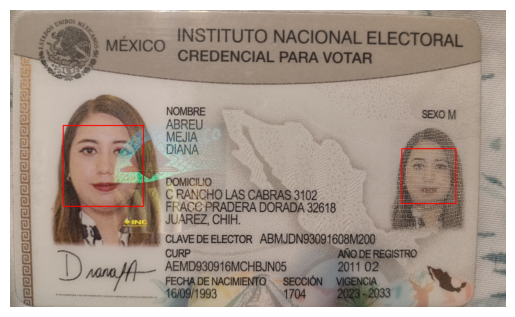

In [332]:
path = '/Users/jorgecamero/MoireDataset/batch'
folders = [os.path.join(path, folder) for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
random_folder = random.choice(folders)

img_list = [os.path.join(random_folder, file) for file in os.listdir(random_folder) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
random_img = random.choice(img_list)
image = cv2.cvtColor(cv2.imread(random_img), cv2.COLOR_BGR2RGB)

image_bbox, conf = get_bbox(image, detector)
color = (255, 0, 0)
for bbox in image_bbox:
        cv2.rectangle(
                image,
                (bbox[0], bbox[1]),
                (bbox[0] + bbox[2], bbox[1] + bbox[3]),
                color, 2)

print(conf)
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
import argparse
import os
from src.train_main import TrainMain
from src.default_config import get_default_config, update_config

conf = get_default_config()
conf = update_config(None, conf=conf)
trainer = TrainMain(conf)
trainer._init_model_param()
trainer._save_state()

lr:  0.1
epochs:  25
milestones:  [10, 15, 22]


/Users/jorgecamero/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [334]:
import os

os.makedirs("./datasets/rgb_image/org_1_80x60", exist_ok=True)

In [7]:
import torch
from torchsummary import summary

model = torch.load("spoofing_model.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3, 80, 60))

model.eval()
input_data = torch.randn(1, 3, 80, 60).to(device)

output = model(input_data)

print("Output type:", type(output))
if isinstance(output, (tuple, list)):
    for i, out in enumerate(output):
        print(f"Output {i}: Type = {type(out)}, Shape = {out.shape}")
else:
    print("Output Shape:", output.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 30]             864
       BatchNorm2d-2           [-1, 32, 40, 30]              64
             PReLU-3           [-1, 32, 40, 30]              32
        Conv_block-4           [-1, 32, 40, 30]               0
            Conv2d-5           [-1, 32, 40, 30]             288
       BatchNorm2d-6           [-1, 32, 40, 30]              64
             PReLU-7           [-1, 32, 40, 30]              32
        Conv_block-8           [-1, 32, 40, 30]               0
            Conv2d-9          [-1, 103, 40, 30]           3,296
      BatchNorm2d-10          [-1, 103, 40, 30]             206
            PReLU-11          [-1, 103, 40, 30]             103
       Conv_block-12          [-1, 103, 40, 30]               0
           Conv2d-13          [-1, 103, 20, 15]             927
      BatchNorm2d-14          [-1, 103,

/var/folders/kd/d9yg9jpx6b9g1z65k4h_h7nm0000gn/T/ipykernel_36490/3397112215.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("spoofing_model.pth")


In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        
        self.densenet = models.densenet121(pretrained=True)
        
        in_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.densenet(x)

num_classes = 2
model = DenseNetClassifier(num_classes)
torch.save(model, "dense_model_checkpoint.pth")

/Users/jorgecamero/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jorgecamero/.pyenv/versions/3.9.7/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [558]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, folder in enumerate(["Reales", "Ataque"]):
            folder_path = os.path.join(directory, folder)
            for filename in os.listdir(folder_path):
                if filename.endswith(('.png', '.jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform = transforms.Compose([
#     transforms.Resize((80, 60)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
#     transforms.RandomRotation(degrees=3),
#     transforms.ToTensor()
# ])

dataset = CustomImageDataset(directory='/Users/jorgecamero/MoireDataset/batch', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
model = torch.load("spoofing_model_checkpoint.pth")
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=5e-5, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

better_loss = math.inf
num_epochs = 50
early_stop_patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with tqdm(total=len(dataloader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix(loss=running_loss / (total // 2), accuracy=correct / total)
            pbar.update(1)

    avg_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {100 * correct / total:.2f}%, lr: {scheduler.get_last_lr()[0]}')
    
    scheduler.step(avg_loss)
    
    if avg_loss < better_loss:
        better_loss = avg_loss
        epochs_no_improve = 0
        torch.save(model, "spoofing_model_checkpoint.pth")
    else:
        epochs_no_improve += 1
    
    # Check for early stopping
    if epochs_no_improve >= early_stop_patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

print('Entrenamiento completado')

/var/folders/kd/d9yg9jpx6b9g1z65k4h_h7nm0000gn/T/ipykernel_1816/2916407425.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("spoofing_model_checkpoint

Epoch [1/50], Loss: 0.1271, Accuracy: 96.97%, lr: 5e-05


Epoch 2/50: 100%|██████████| 91/91 [01:34<00:00,  1.03s/batch, accuracy=0.971, loss=0.0109] 


Epoch [2/50], Loss: 0.0870, Accuracy: 97.10%, lr: 5e-05


Epoch 3/50: 100%|██████████| 91/91 [01:34<00:00,  1.03s/batch, accuracy=0.98, loss=0.00804] 


Epoch [3/50], Loss: 0.0641, Accuracy: 98.00%, lr: 5e-05


Epoch 4/50: 100%|██████████| 91/91 [01:34<00:00,  1.04s/batch, accuracy=0.975, loss=0.00855]


Epoch [4/50], Loss: 0.0682, Accuracy: 97.52%, lr: 5e-05


Epoch 5/50: 100%|██████████| 91/91 [01:35<00:00,  1.05s/batch, accuracy=0.97, loss=0.00934] 


Epoch [5/50], Loss: 0.0744, Accuracy: 97.03%, lr: 5e-05


Epoch 6/50: 100%|██████████| 91/91 [01:35<00:00,  1.05s/batch, accuracy=0.981, loss=0.0077] 


Epoch [6/50], Loss: 0.0614, Accuracy: 98.07%, lr: 5e-05


Epoch 7/50: 100%|██████████| 91/91 [01:34<00:00,  1.04s/batch, accuracy=0.977, loss=0.00866]


Epoch [7/50], Loss: 0.0690, Accuracy: 97.66%, lr: 5e-05


Epoch 8/50: 100%|██████████| 91/91 [01:34<00:00,  1.04s/batch, accuracy=0.979, loss=0.00496]


Epoch [8/50], Loss: 0.0396, Accuracy: 97.86%, lr: 5e-05


Epoch 9/50: 100%|██████████| 91/91 [01:34<00:00,  1.04s/batch, accuracy=0.983, loss=0.00521]


Epoch [9/50], Loss: 0.0415, Accuracy: 98.34%, lr: 5e-05


Epoch 10/50: 100%|██████████| 91/91 [01:35<00:00,  1.05s/batch, accuracy=0.989, loss=0.00482]


Epoch [10/50], Loss: 0.0384, Accuracy: 98.90%, lr: 5e-05


Epoch 11/50: 100%|██████████| 91/91 [01:36<00:00,  1.06s/batch, accuracy=0.986, loss=0.00424]


Epoch [11/50], Loss: 0.0338, Accuracy: 98.55%, lr: 5e-05


Epoch 12/50: 100%|██████████| 91/91 [01:34<00:00,  1.04s/batch, accuracy=0.99, loss=0.00358] 


Epoch [12/50], Loss: 0.0285, Accuracy: 99.03%, lr: 5e-05


Epoch 13/50: 100%|██████████| 91/91 [01:34<00:00,  1.03s/batch, accuracy=0.989, loss=0.00403]


Epoch [13/50], Loss: 0.0321, Accuracy: 98.90%, lr: 5e-05


Epoch 14/50: 100%|██████████| 91/91 [01:34<00:00,  1.04s/batch, accuracy=0.99, loss=0.00347] 


Epoch [14/50], Loss: 0.0276, Accuracy: 99.03%, lr: 5e-05


Epoch 15/50: 100%|██████████| 91/91 [01:35<00:00,  1.04s/batch, accuracy=0.995, loss=0.00194]


Epoch [15/50], Loss: 0.0154, Accuracy: 99.52%, lr: 5e-05


Epoch 16/50: 100%|██████████| 91/91 [01:33<00:00,  1.02s/batch, accuracy=0.99, loss=0.00365] 


Epoch [16/50], Loss: 0.0291, Accuracy: 99.03%, lr: 5e-05


Epoch 17/50: 100%|██████████| 91/91 [01:33<00:00,  1.03s/batch, accuracy=0.992, loss=0.00237]


Epoch [17/50], Loss: 0.0189, Accuracy: 99.24%, lr: 5e-05


Epoch 18/50: 100%|██████████| 91/91 [01:33<00:00,  1.03s/batch, accuracy=0.996, loss=0.00219]


Epoch [18/50], Loss: 0.0174, Accuracy: 99.59%, lr: 5e-05


Epoch 19/50: 100%|██████████| 91/91 [01:34<00:00,  1.03s/batch, accuracy=0.994, loss=0.00289]


Epoch [19/50], Loss: 0.0230, Accuracy: 99.38%, lr: 5e-05


Epoch 20/50: 100%|██████████| 91/91 [01:33<00:00,  1.03s/batch, accuracy=0.995, loss=0.00183]


Epoch [20/50], Loss: 0.0146, Accuracy: 99.52%, lr: 5e-05


Epoch 21/50: 100%|██████████| 91/91 [01:34<00:00,  1.04s/batch, accuracy=0.997, loss=0.0017] 


Epoch [21/50], Loss: 0.0135, Accuracy: 99.72%, lr: 5e-05


Epoch 22/50: 100%|██████████| 91/91 [01:37<00:00,  1.07s/batch, accuracy=0.997, loss=0.00159]


Epoch [22/50], Loss: 0.0127, Accuracy: 99.72%, lr: 5e-05


Epoch 23/50: 100%|██████████| 91/91 [57:28<00:00, 37.90s/batch, accuracy=0.997, loss=0.00187]   


Epoch [23/50], Loss: 0.0149, Accuracy: 99.72%, lr: 5e-05


Epoch 24/50: 100%|██████████| 91/91 [37:21<00:00, 24.63s/batch, accuracy=0.993, loss=0.0024]    


Epoch [24/50], Loss: 0.0191, Accuracy: 99.31%, lr: 5e-05


Epoch 25/50: 100%|██████████| 91/91 [02:34<00:00,  1.69s/batch, accuracy=0.996, loss=0.00192]


Epoch [25/50], Loss: 0.0153, Accuracy: 99.59%, lr: 5e-05


Epoch 26/50: 100%|██████████| 91/91 [58:32<00:00, 38.60s/batch, accuracy=0.997, loss=0.00156]   


Epoch [26/50], Loss: 0.0124, Accuracy: 99.72%, lr: 5e-05


Epoch 27/50: 100%|██████████| 91/91 [02:17<00:00,  1.51s/batch, accuracy=0.997, loss=0.00163]


Epoch [27/50], Loss: 0.0130, Accuracy: 99.66%, lr: 5e-05


Epoch 28/50: 100%|██████████| 91/91 [02:14<00:00,  1.48s/batch, accuracy=0.996, loss=0.00197]


Epoch [28/50], Loss: 0.0157, Accuracy: 99.59%, lr: 5e-05


Epoch 29/50: 100%|██████████| 91/91 [02:14<00:00,  1.48s/batch, accuracy=0.996, loss=0.00183] 


Epoch [29/50], Loss: 0.0146, Accuracy: 99.59%, lr: 5e-05


Epoch 30/50: 100%|██████████| 91/91 [02:14<00:00,  1.48s/batch, accuracy=0.996, loss=0.00162]


Epoch [30/50], Loss: 0.0129, Accuracy: 99.59%, lr: 5e-05


Epoch 31/50: 100%|██████████| 91/91 [02:16<00:00,  1.50s/batch, accuracy=0.994, loss=0.00271]


Epoch [31/50], Loss: 0.0216, Accuracy: 99.45%, lr: 5e-05


Epoch 32/50: 100%|██████████| 91/91 [02:15<00:00,  1.49s/batch, accuracy=0.998, loss=0.00137] 


Epoch [32/50], Loss: 0.0109, Accuracy: 99.79%, lr: 5e-05


Epoch 33/50: 100%|██████████| 91/91 [09:21<00:00,  6.17s/batch, accuracy=0.997, loss=0.00159] 


Epoch [33/50], Loss: 0.0127, Accuracy: 99.72%, lr: 5e-05


Epoch 34/50: 100%|██████████| 91/91 [51:13<00:00, 33.77s/batch, accuracy=0.998, loss=0.00109]    


Epoch [34/50], Loss: 0.0087, Accuracy: 99.79%, lr: 5e-05


Epoch 35/50: 100%|██████████| 91/91 [1:32:13<00:00, 60.81s/batch, accuracy=0.997, loss=0.00129]   


Epoch [35/50], Loss: 0.0103, Accuracy: 99.72%, lr: 5e-05


Epoch 36/50:  41%|████      | 37/91 [42:36<1:02:10, 69.09s/batch, accuracy=0.995, loss=0.00126] 


KeyboardInterrupt: 

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from IPython.display import clear_output

def test_image(model, image_jpg, threshold=0.5):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if isinstance(image_jpg, str):
        image_jpg = Image.open(image_jpg)
    
    image = transform(image_jpg).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        probabilities_logits = model(image)
        probabilities = torch.softmax(probabilities_logits, dim=1)
        Real_pred = probabilities[0, 0].item()
        Ataque_pred = probabilities[0, 1].item()
        
    return Ataque_pred >= threshold, Ataque_pred

def predict(model, image):
    if isinstance(image, str):
        image = Image.open(image)
        
    image_180 = image.rotate(180, expand=True)    
    image_180_flip = image_180.transpose(Image.FLIP_LEFT_RIGHT)
    
    atack_cnt = 0
    if test_image(model, image)[0]:
        atack_cnt += 1

    if test_image(model, image_180)[0]:
        atack_cnt += 1

    if test_image(model, image_180_flip)[0]:
        atack_cnt += 1
    
    prediction_bool = atack_cnt > 1
    score = atack_cnt/3
    
    return prediction_bool, score

Modelo guardado como TorchScript (trazado) en traced_model.pt
0.9991150498390198


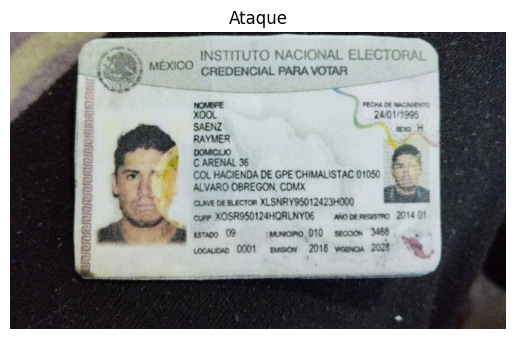

In [ ]:
from PIL import Image
import os
import random
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")

model = torch.load("spoofing_model_checkpoint.pth", map_location=device, weights_only=False)
model.to(device)

path = '/Users/jorgecamero/MoireDataset/batch'
folders = [os.path.join(path, folder) for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
random_folder = random.choice(folders)

img_list = [os.path.join(random_folder, file) for file in os.listdir(random_folder) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
random_img = random.choice(img_list)
image = Image.open(random_img).convert("RGB")

model = torch.load("spoofing_model_checkpoint.pth", map_location=device, weights_only=False)
prediction_bool, prediction = test_image(model, image)
print(prediction)

plt.imshow(image)
plt.title(os.path.basename(random_folder))
plt.axis('off')
plt.show()

1.0


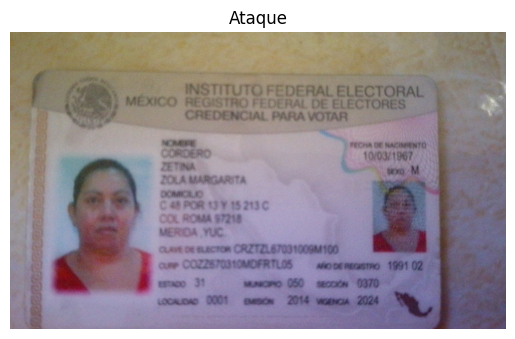

In [37]:
from PIL import Image
import os
import random
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")

model = torch.load("spoofing_model_checkpoint.pth", map_location=device, weights_only=False)
model.to(device)

path = '/Users/jorgecamero/MoireDataset/batch'
folders = [os.path.join(path, folder) for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
random_folder = random.choice(folders)

img_list = [os.path.join(random_folder, file) for file in os.listdir(random_folder) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
random_img = random.choice(img_list)
image = Image.open(random_img).convert("RGB")

model = torch.load("spoofing_model_checkpoint.pth", map_location=device, weights_only=False)
prediction_bool, prediction = predict(model, image)
print(prediction)

plt.imshow(image)
plt.title(os.path.basename(random_folder))
plt.axis('off')
plt.show()

In [ ]:
import os
from tqdm import tqdm

path = '/Users/jorgecamero/MoireDataset/mergeDataset/Reales'

img_list = [os.path.join(path, file) for file in os.listdir(path) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]

cnt = 0
progress_bar = tqdm(img_list, desc="Procesando imágenes")
model = torch.load("spoofing_model_checkpoint.pth", map_location=device, weights_only=False)
for img_path in progress_bar:
    if test_image(model, img_path):
        cnt += 1

    progress_bar.set_postfix({'Imágenes detectadas': cnt})

Procesando imágenes:   0%|          | 72/14507 [00:08<27:19,  8.81it/s, Imágenes detectadas=72]


KeyboardInterrupt: 

Atack_conf: 100.00%
Predicción: Ataque


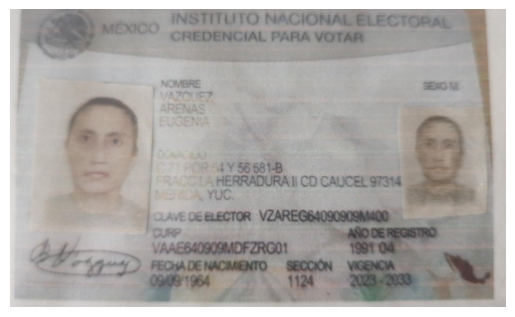

In [12]:
from PIL import Image
import torch
import io
import os

device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")

path = '/Users/jorgecamero/Downloads/fwinesfalsas'
imgs = [os.path.join(path, file) for file in os.listdir(path) if file.lower().endswith('.jfif')]

with open(imgs[6], 'rb') as file:
    image = Image.open(file)
    image = image.convert("RGB")

buffer = io.BytesIO()
image.save(buffer, format='JPEG')

buffer.seek(0)
image_jpg = Image.open(buffer)

model = torch.load("spoofing_model_checkpoint.pth", map_location=device, weights_only=False)
prediction_bool, score = test_image(model, image_jpg)

prediction_label = 'Real' if not prediction_bool else 'Ataque'
print(f"Atack_conf: {100*score:.2f}%")
    
print(f"Predicción: {prediction_label}")

plt.imshow(image_jpg)
plt.axis('off')
plt.show()

## COPIAR FOTOS

In [15]:
import os
import shutil
from tqdm import tqdm
import pandas as pd


output_dir = 'Ataque'
os.makedirs(output_dir, exist_ok=True)

folders = ['fail', 'pass']
root = '/Users/jorgecamero/Moire-Fraud-Detection'

df = pd.read_excel('/Users/jorgecamero/Desktop/Moire.xlsx', sheet_name=2)

for idx, row in tqdm(enumerate(df.iterrows()), desc="Archivos procesados", total=len(df)):
    file_name = df.at[idx, 'file']

    for folder in folders:
        file_path = os.path.join(root, folder, file_name)
        
        if os.path.exists(file_path):
            if df.at[idx, 'label real'] == 'FAIL' and df.at[idx, 'prediction nueva'] == 'PASS':
                shutil.copyfile(file_path, os.path.join(output_dir, os.path.basename(file_path)))

Archivos procesados: 100%|██████████| 4649/4649 [00:00<00:00, 20747.71it/s]


## Procesar fotos con modelo

In [14]:
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

model = torch.load("spoofing_model_checkpoint.pth", map_location=device, weights_only=False)
folders = ['fail', 'pass']
root = '/Users/jorgecamero/Moire-Fraud-Detection'

df = pd.read_excel('/Users/jorgecamero/Desktop/Moire.xlsx', sheet_name=2)
df['prediction'] = df['prediction'].astype(str)
df['prediction nueva'] = df['prediction nueva'].astype(str)

for idx, row in tqdm(enumerate(df.iterrows()), desc="Archivos procesados", total=len(df)):
    file_name = df.at[idx, 'file']

    for folder in folders:
        file_path = os.path.join(root, folder, file_name)
        
        if os.path.exists(file_path):
            prediction_bool, score = test_image(model, file_path, threshold=0.5)
            df.at[idx, 'prediction nueva'] = 'FAIL' if prediction_bool else 'PASS'
            
df = df.iloc[:, :4]

df.to_excel('/Users/jorgecamero/Desktop/Moire_303.xlsx')

Archivos procesados: 100%|██████████| 4649/4649 [07:32<00:00, 10.27it/s]


In [467]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

df = pd.read_excel('/Users/jorgecamero/Desktop/Moire.xlsx', sheet_name=0)

len(df)

TP = 0
TN = 0
FP = 0
FN = 0

column = 'prediction nueva'
# column = 'prediction'
for idx, row in enumerate(df.iterrows()):
    true_label = df.at[idx, 'label real']
    if true_label == 'FAIL':
        if df.at[idx, column] == 'PASS':
            FP += 1
        elif df.at[idx, column] == 'FAIL':
            TP += 1

    elif true_label == 'PASS':
        if df.at[idx, column] == 'PASS':
            TN += 1
        elif df.at[idx, column] == 'FAIL':
            FN += 1
            
print("TP", TP)
print("TN", TN)
print("FP", FP)
print("FN", FN)

TP 273
TN 3761
FP 0
FN 478


In [456]:
df = pd.read_excel('/Users/jorgecamero/Desktop/Moire.xlsx', sheet_name=1)

len(df)

TP = 0
TN = 0

column = 'prediction'
# column = 'prediction'
for idx, row in enumerate(df.iterrows()):
    true_label = df.at[idx, 'label real']
    if true_label == 'FAIL':
        TP += 1
    elif true_label == 'PASS':
        TN += 1
        
print("TP", TP)
print("TN", TN)

TP 0
TN 2


In [396]:
import os
import shutil
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

folders = ['fail', 'pass']
root = '/Users/jorgecamero/Moire-Fraud-Detection'

df = pd.read_excel('/Users/jorgecamero/Desktop/Moire_mod.xlsx')
output_dir = 'Real'
os.makedirs(output_dir, exist_ok=True)

for idx, row in tqdm(enumerate(df.iterrows()), desc="Archivos procesados", total=len(df)):
    file_name = df.at[idx, 'file']

    for folder in folders:
        file_path = os.path.join(root, folder, file_name)
        
        if os.path.exists(file_path):
            if df.at[idx, 'label real'] == 'PASS':
                shutil.copyfile(file_path, os.path.join(output_dir, os.path.basename(file_path)))
        
df.to_excel('/Users/jorgecamero/Desktop/Moire.xlsx')

Archivos procesados: 100%|██████████| 4512/4512 [00:08<00:00, 530.08it/s]
